## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [2]:
# pandas and numpy
import pandas as pd
import numpy as numpy

# emoji for preprocessing
#!pip install emoji
import emoji

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# load data 
# ----------
congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
congress_tweets.head()


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,1.081010e+18,RepByrne,2019-01-03T21:23:00-05:00,Great news for Baldwin County! The economy of ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
1,1.080880e+18,RepByrne,2019-01-03T12:30:38-05:00,Outstanding news today from @Airbus! @JetBlue ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
2,1.080830e+18,RepByrne,2019-01-03T09:12:07-05:00,RT @senatemajldr Democrats will have to get se...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
3,1.080890e+18,RepByrne,2019-01-03T13:20:53-05:00,Here is a sign of things to come: As Democrats...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
4,1.080870e+18,RepByrne,2019-01-03T12:10:26-05:00,Let's understand what we're dealing with here:...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"


In [4]:
## limiting sample to 5000 tweets (large enough to hopefully catch most oddities) 
congress_tweets_sample = congress_tweets.sample(n=5000)

#visualizing column
congress_tweets_sample['text']

478626    All eyes on Georgia. @Ossoff &amp; @ReverendWa...
821487    Although part of me would like to see Ds squan...
495203    This mirrors the successful efforts to reduce ...
234467    Sorry, Mr. Pence, but as we say in the South, ...
130955    RT @GOPoversight "Mob rule presents a serious ...
                                ...                        
40532     The choice to try hydroxychloroquine should no...
918860    Dr. Fauci has served Democratic and Republican...
176081    Whether or not Trump “likes” Chairman Kim is n...
548426    Yesterday marked my final @IndianCommittee hea...
78369     I spoke on the House floor to recognize June a...
Name: text, Length: 5000, dtype: object

## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [6]:
def rem_punc_stop(text):
    # set objects
    stop_words = STOP_WORDS
    additional_stops = {'u', 'e', 'eHouse'} # I identified these after creating a few wordclouds iteratively
    stop_words.update(additional_stops)
    punc = set(punctuation)
    
    # First split into words
    words = text.split()
    cleaned_words = []
    i = 0
    
    while i < len(words):
        # Remove RT/QT and skip the next word (username) if it's a retweet/quote tweet pattern
        if (i < len(words) - 1 and 
            (words[i] == "RT" or words[i] == "QT") and 
            words[i + 1].startswith("@")):
            i += 2  # Skip both RT/QT and the @username
        # Remove any @username mentions
        elif words[i].startswith("@"):
            i += 1  # Skip the @username
        # Remove standalone RT, QT
        elif words[i] in ["RT", "QT"]:
            i += 1
        else:
            cleaned_words.append(words[i])
            i += 1
    
    # Join back into text
    text = " ".join(cleaned_words)
    
    # remove punctuation
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    # remove emojis using emoji library
    punc_free = emoji.replace_emoji(punc_free, '')
    
    # remove URL
    words = punc_free.split()
    punc_free = " ".join([word for word in words if not word.startswith(('http', 'https', 'www'))])
    
    # Remove extra whitespace created by removals
    punc_free = " ".join(punc_free.split())
    
    # apply nlp to punctuation-free object
    doc = nlp(punc_free)
    
    # extract words from processed text
    spacy_words = [token.text for token in doc]
    
    # filter out words
    spacy_words = [word for word in spacy_words if not word.startswith('http')]
    
    # Remove 'amp' from the word list (identified after initial cleaning and making a wordcloud; doubled back to remove
    no_punc = [word for word in spacy_words if word not in stop_words and word != 'amp']
    
    # return
    return no_punc

In [7]:
# Test on one tweet
sample_tweet = congress_tweets_sample['text'].iloc[0]
print("Original:", sample_tweet)
print("Processed:", rem_punc_stop(sample_tweet))

Original: All eyes on Georgia. @Ossoff &amp; @ReverendWarnock will rubber-stamp Schumer, Pelosi and the Squad’s RADICAL liberal agenda. We can’t let this happen.

We MUST re-elect @KLoeffler &amp; @Perduesenate and #SaveTheSenate!

#HoldTheLine #GASen #GApol https://www.gabattleground.com/
Processed: ['All', 'eyes', 'Georgia', 'rubberstamp', 'Schumer', 'Pelosi', 'Squad', 'RADICAL', 'liberal', 'agenda', 'We', 'let', 'happen', 'We', 'MUST', 'reelect', 'SaveTheSenate', 'HoldTheLine', 'GASen', 'GApol']


In [8]:
# apply function to the 'text' column in the sample rows from the dataset
congress_tweets_sample['tokens'] = congress_tweets_sample['text'].map(lambda x: rem_punc_stop(x))

# visualize
congress_tweets_sample['tokens']

478626    [All, eyes, Georgia, rubberstamp, Schumer, Pel...
821487    [Although, like, Ds, squander, resources, losi...
495203    [This, mirrors, successful, efforts, reduce, t...
234467    [Sorry, Mr, Pence, South, No, ma’am, insisted,...
130955    [Mob, rule, presents, threat, American, way, l...
                                ...                        
40532     [The, choice, try, hydroxychloroquine, healthc...
918860    [Dr, Fauci, served, Democratic, Republican, ad...
176081    [Whether, Trump, “, likes, ”, Chairman, Kim, r...
548426    [Yesterday, marked, final, hearing, I, nt, ove...
78369     [I, spoke, House, floor, recognize, June, Alzh...
Name: tokens, Length: 5000, dtype: object

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1

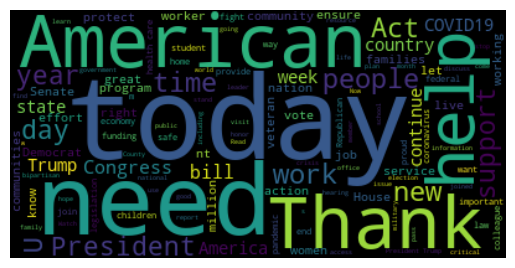

In [9]:
# Wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# ----------
# apply function to text object
text = ' '.join(congress_tweets_sample['tokens'].map(lambda text: ' '.join(text)))

# create WordCloud visualization using the "text" object 
wordcloud = WordCloud(random_state=40).generate(text) # set random state to ensure same word cloud each time

# plot 
plt.imshow(wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.show()                             # show the plot

### EDA 2

In [31]:
...

Ellipsis

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

In [32]:
...

Ellipsis

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

In [33]:
...

Ellipsis

### Engineered Text Features

In [34]:
# Engineered Features
...

### Bag-of-words or Tf-idf

In [35]:
# Frequency Based featurization
...

### Word Embedding

In [36]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

#model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary = True) 

In [37]:
# Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)

In [38]:
# embedding based featurization
...

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [39]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])
...

### Two Combined Models

In [40]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])
...

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

**YOUR ANSWER HERE** ...

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**YOUR ANSWER HERE** ...

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

**YOUR ANSWER HERE** ...

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

**YOUR ANSWER HERE** ...